In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from sktime.utils.plotting import plot_correlations





plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

### Примеры нестационарных рядов

In [2]:
beta_0 = 1
beta_1 = 0.5
sigma_sq = 16
n_steps = 1000

y_det = [beta_0 + beta_1 * t + np.random.normal(scale=sigma_sq) for t in range(n_steps)]

y_stoch = [0]
[y_stoch.append(beta_0 + y_stoch[-1] + np.random.normal(scale=sigma_sq)) for t in range(n_steps)]

y_det = pd.Series(y_det)
y_stoch = pd.Series(y_stoch)

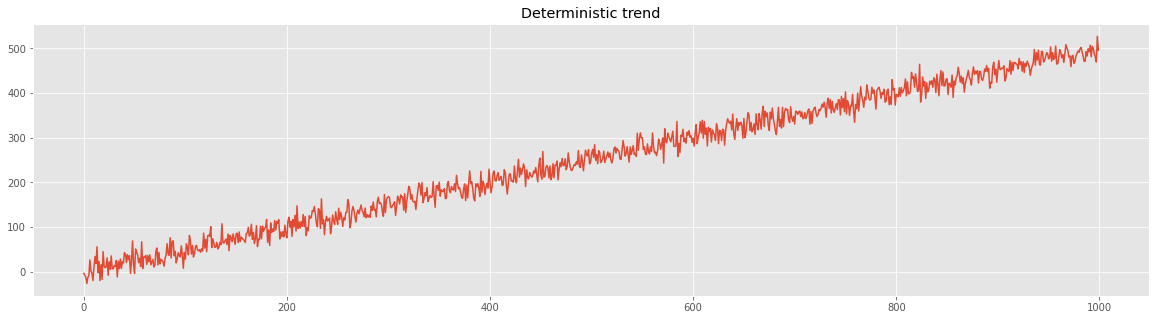

In [3]:
y_det.plot()
plt.title("Deterministic trend");

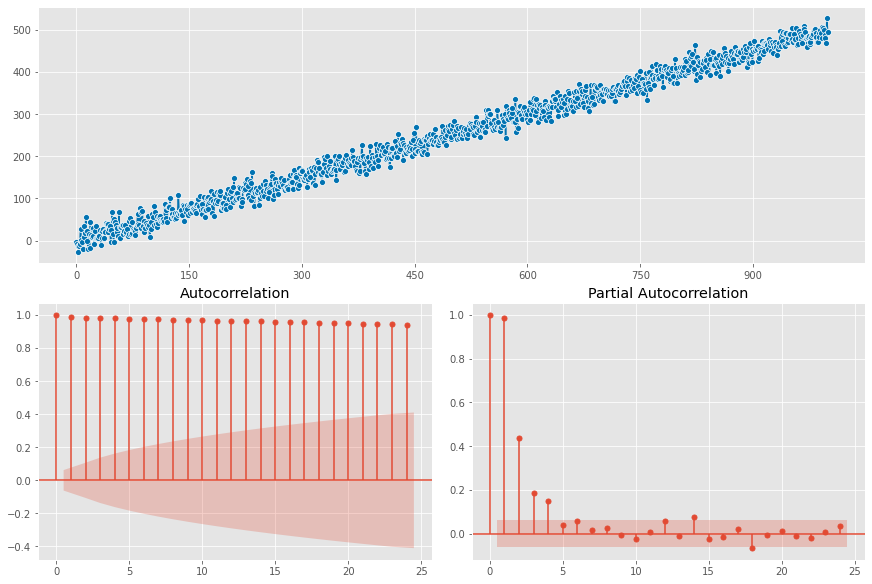

In [4]:
plot_correlations(y_det);

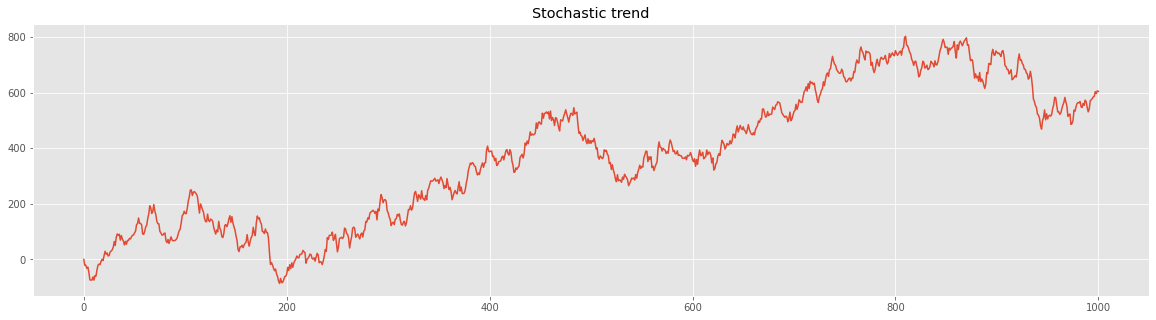

In [5]:
y_stoch.plot()
plt.title("Stochastic trend");

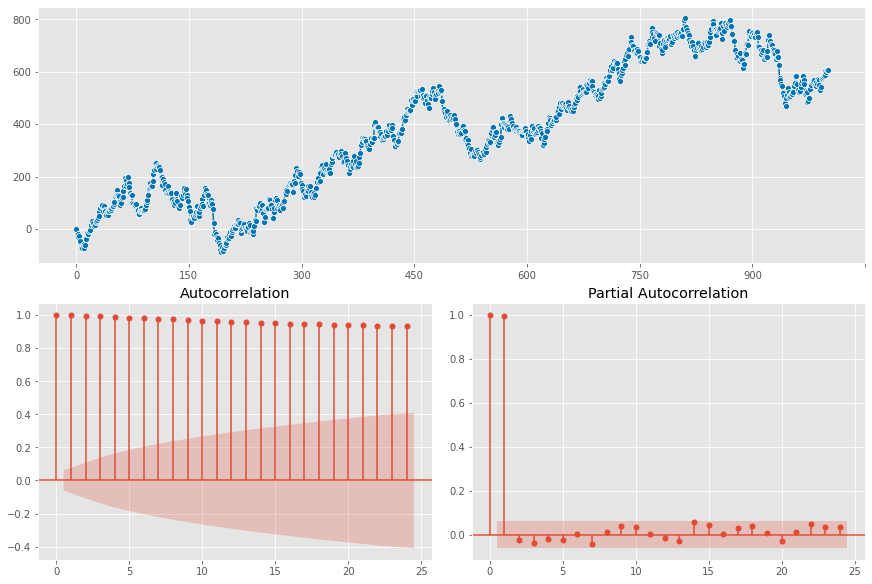

In [6]:
plot_correlations(y_stoch);


Теперь посмотрим на какие-нибудь нестационарные процессы и попытаемся оценить на них SARIMA-модель.

In [7]:
import statsmodels.api as sm
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

test_size = 20

data = sm.datasets.macrodata.load_pandas().data

train, test = temporal_train_test_split(data['realgdp'], test_size = test_size)

Возьмём какой-нибудь нестационарный ряд.

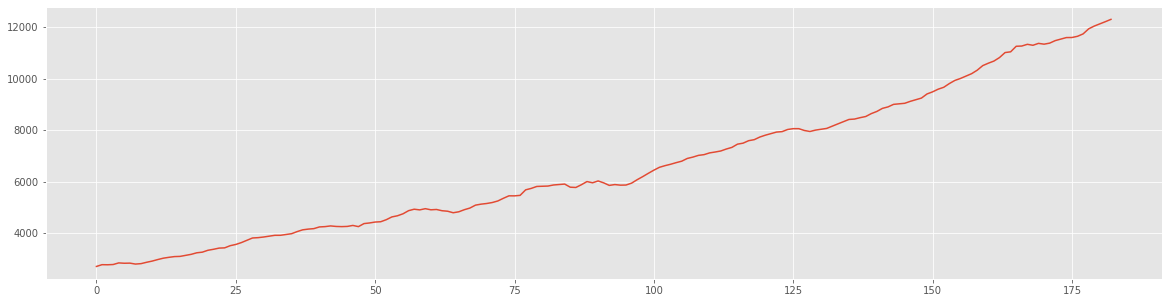

In [8]:
train.plot();

In [9]:
from statsmodels.tsa.stattools import kpss

# Гипотеза о стационарности отвергается
kpss(train)


/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.2937964667167519,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [10]:
# Гипотеза отвергается на 5-процентном уровне значимости. 
kpss(train.diff().dropna())

(0.7069593202135732,
 0.012912789071493343,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [11]:
# Гипотеза не отвергается на 5-процентном уровне значимости. 
kpss(train.diff().diff().dropna())

/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.046564676845442264,
 0.1,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [12]:
dgdp = train.diff().diff().dropna()

<AxesSubplot:>

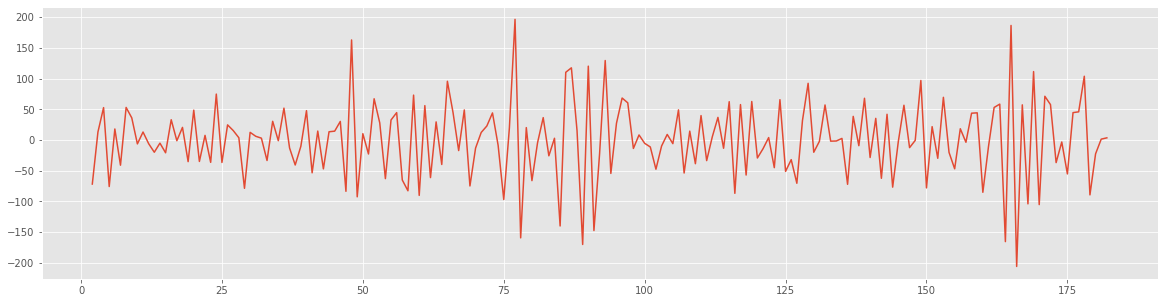

In [13]:
dgdp.plot()

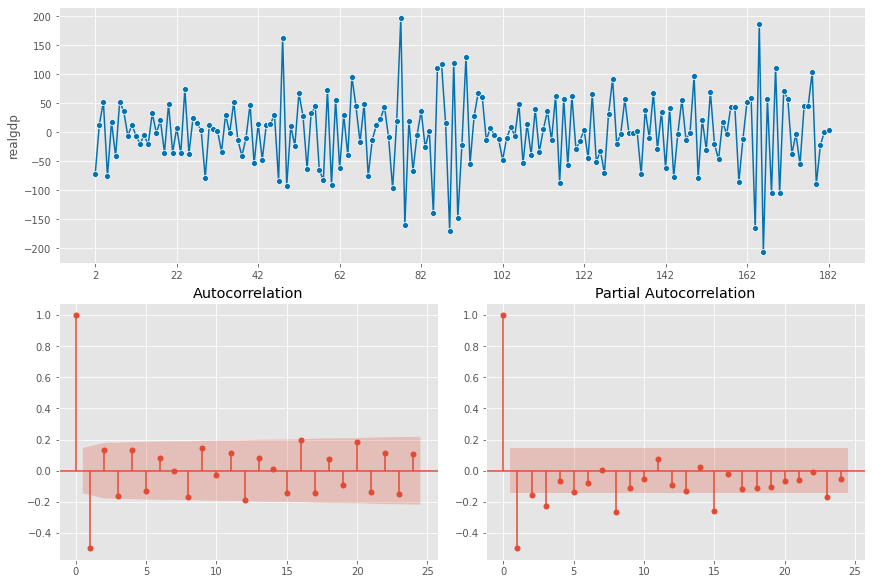

In [14]:
plot_correlations(dgdp);

In [21]:
from sktime.forecasting.base import ForecastingHorizon

In [22]:
max_p = 5
max_q = 1

orders = []

for p in range(max_p+1):
    for q in range(max_q+1):
        orders.append((p, 2, q))
        
fh = ForecastingHorizon(list(range(1, test_size+1)))


In [24]:
fh

ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20],
           dtype='int64', is_relative=True)

In [17]:
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV


cv = ExpandingWindowSplitter(
    start_with_window=True,
    fh=fh,
    step_length=test_size)

forecaster = ARIMA()
param_grid = {"order" : orders}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv)
gscv.fit(train)
# pred = gscv.predict(fh)

/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/the_sun/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
            initial_window=None, step_length=20),
                        forecaster=ARIMA(),
                        param_grid={'order': [(0, 2, 0), (0, 2, 1), (1, 2, 0),
                                              (1, 2, 1), (2, 2, 0), (2, 2, 1),
                                              (3, 2, 0), (3, 2, 1), (4, 2, 0),
                                              (4, 2, 1), (5, 2, 0),
                                              (5, 2, 1)]})

<AxesSubplot:>

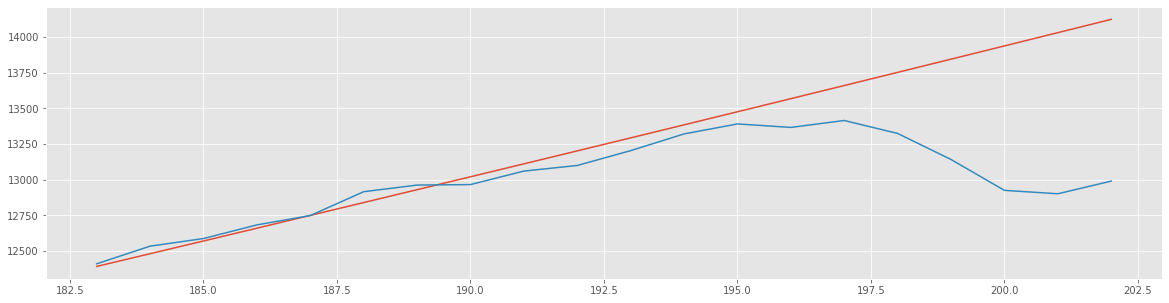

In [26]:
pred = gscv.best_forecaster_.predict(fh)

pred.plot()
test.plot()

<AxesSubplot:>

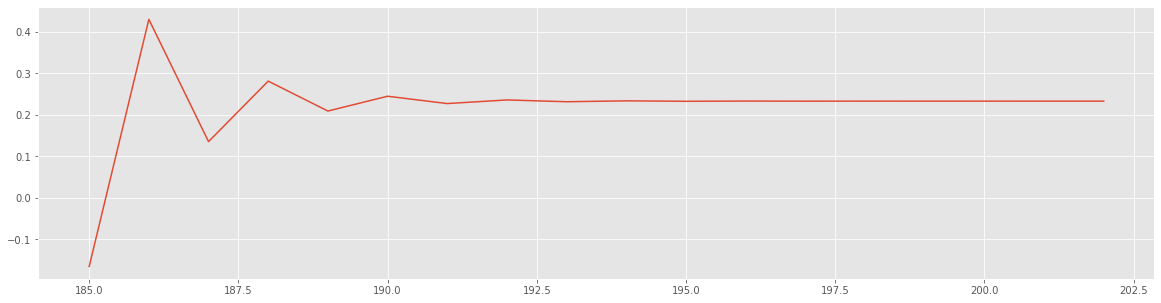

In [30]:
pred.diff().diff().plot()

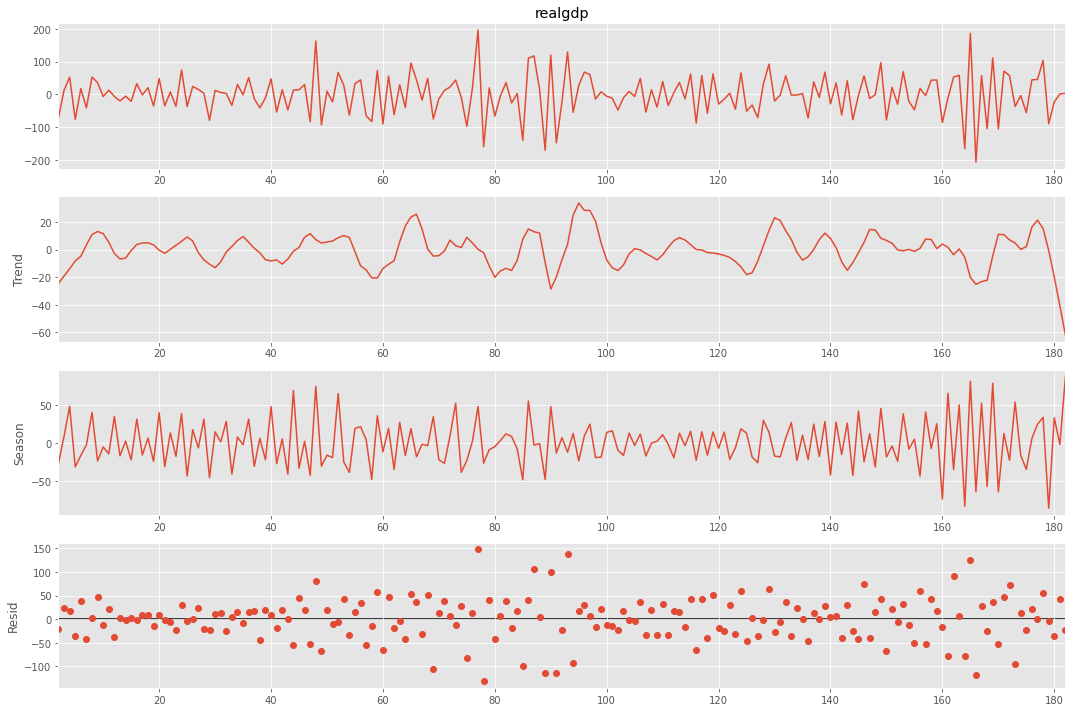

In [34]:
from statsmodels.tsa.seasonal import STL
plt.rcParams["figure.figsize"] = (15,10)

stl = STL(train.diff().diff().dropna(), period=4)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

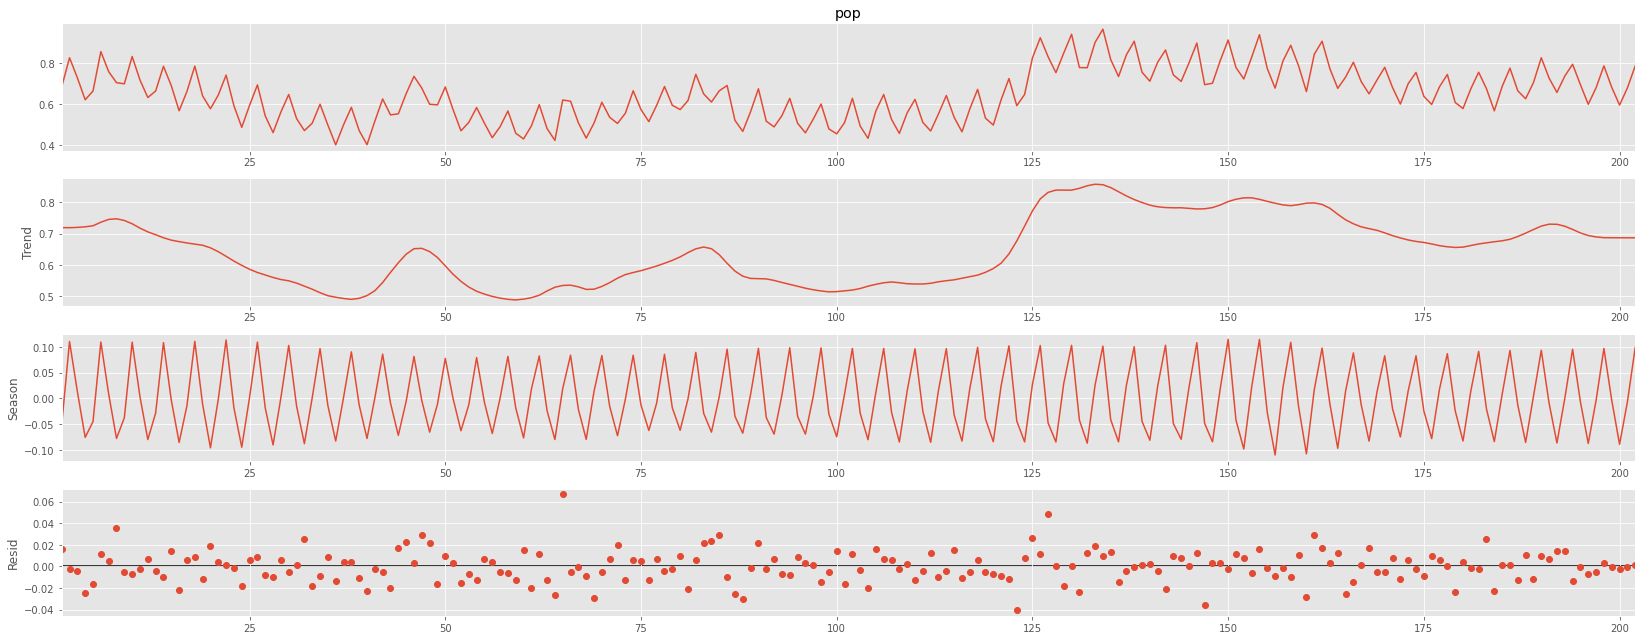

In [44]:

stl = STL(data['pop'].diff().dropna(), period=4)
res = stl.fit()
res.plot();

plt.rcParams["figure.figsize"] = (23,9)

In [45]:
seas_strength = max(0, 1 - res.resid.std()**2 / (res.resid.std()**2 + res.seasonal.std()**2))

In [46]:
seas_strength

0.9534029998538786